In [1]:
import pathlib

import cmocean.cm
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.interpolate
import scipy.stats


%matplotlib inline

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# based on the raw data in 
# https://repos.deltares.nl/repos/zandmotor/trunk/meteohydro/xband/raw/logfiles/2016_05/2016-05-01%2001.52.45UTC.log

url = pathlib.Path('~/Downloads/xband_resolution_200m_2016.nc').expanduser()



In [3]:
ds = netCDF4.Dataset(str(url))

In [4]:
lat = ds.variables['Lat'][0]
lon = ds.variables['Lon'][0]
times = netCDF4.num2date(ds.variables['Time'][:], ds.variables['Time'].units)

In [5]:
def resample(arr, scale=1, fill_value=0.0, k=2):
    
    mask = hasattr(arr, 'mask')
    rows, cols = arr.shape
    u = np.linspace(0, rows, num=rows)
    v = np.linspace(0, cols, num=cols)
    if k == 0:
        Y, X = np.meshgrid(v, u)
        Z = scipy.interpolate.NearestNDInterpolator(np.c_[X.ravel(), Y.ravel()], arr.filled().ravel())
    else:
        Z = scipy.interpolate.RectBivariateSpline(x=u, y=v, z=arr.filled(0), kx=k, ky=k)
    if mask:
        if k == 0:
            Z_mask = scipy.interpolate.NearestNDInterpolator(np.c_[X.ravel(), Y.ravel()], arr.mask.ravel())
        else:
            Z_mask = scipy.interpolate.RectBivariateSpline(x=u, y=v, z=arr.mask, kx=k, ky=k)
    new_rows = rows * scale
    new_cols = cols * scale
    new_u = np.linspace(0, rows, num=new_rows)
    new_v = np.linspace(0, cols, num=new_cols)
    # compute iinterpolated values
    if k == 0:
        Y_new, X_new = np.meshgrid(new_v, new_u)
        interpolated = Z(np.c_[X_new.ravel(), Y_new.ravel()]).reshape((new_rows, new_cols))
    else:
        interpolated = Z(new_u, new_v).reshape((new_rows, new_cols))
    # compute interpolated mask
    if mask:
        if k == 0:
            interpolated_mask = Z_mask(np.c_[X_new.ravel(), Y_new.ravel()]).reshape((new_rows, new_cols))
        else:
            interpolated_mask = Z_mask(new_u, new_v).reshape((new_rows, new_cols))
        # computation is based on masked value
        return np.ma.masked_array(interpolated, mask=interpolated_mask>0.5)
    return interpolated

    


In [6]:
N_current = matplotlib.colors.Normalize(0, 3, clip=True)
N_period = matplotlib.colors.Normalize(0, 40, clip=True)

for i, t_i in enumerate(times):
    current_angle = ds.variables['CAngle'][i]
    current_angle_masked = np.ma.masked_invalid(current_angle)
    current_angle_masked_resampled = resample(current_angle_masked, scale=10, k=0)
    # curent from north -> 180 + -> current to -> 90 - -> ccw east
    current_angle_masked_resampled_radian = np.mod(np.deg2rad(90 + current_angle_masked_resampled), np.pi*2)

    current = ds.variables['Current'][i]
    current_masked = np.ma.masked_invalid(current)
    current_masked_resampled = resample(current_masked, scale=10, k=0)
    current_masked_resampled_normalized = N_current(current_masked_resampled)
    
    U = np.ma.cos(current_angle_masked_resampled_radian)
    V = np.ma.sin(current_angle_masked_resampled_radian)
    R = U.filled(0) * current_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    G = V.filled(0) * current_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    B = np.logical_or(current_masked_resampled_normalized.mask, current_angle_masked_resampled_radian.mask)
    RGB = np.dstack([R, G, B])
    plt.imsave('radar_current_{:06d}.png'.format(i), RGB)

    
    wave_angle = ds.variables['WAngle'][i:i+10]
    wave_angle_masked = np.ma.masked_invalid(wave_angle)
    # compute mean along last axis
    wave_angle_masked_radian = np.ma.masked_invalid(scipy.stats.circmean(np.mod(np.deg2rad(90 + wave_angle_masked), np.pi*2), axis=0))
    wave_angle_masked_resampled_radian = resample(wave_angle_masked_radian, scale=10, k=0)

    wave_period = ds.variables['Period'][i]
    wave_period_masked = np.ma.masked_invalid(wave_period)
    wave_period_masked_resampled = resample(wave_period_masked, scale=10, k=0)
    wave_period_masked_resampled_normalized = N_period(wave_period_masked_resampled)
    
    U = np.ma.cos(wave_angle_masked_resampled_radian)
    V = np.ma.sin(wave_angle_masked_resampled_radian)
    R = U.filled(0) * wave_period_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    G = V.filled(0) * wave_period_masked_resampled_normalized.filled(0) * 0.5 + 0.5
    B = np.logical_or(wave_period_masked_resampled_normalized.mask, wave_angle_masked_resampled_radian.mask)
    RGB = np.dstack([R, G, B])
    plt.imsave('radar_waves_{:06d}.png'.format(i), RGB)
    

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


TypeError: Invalid dimensions for image data

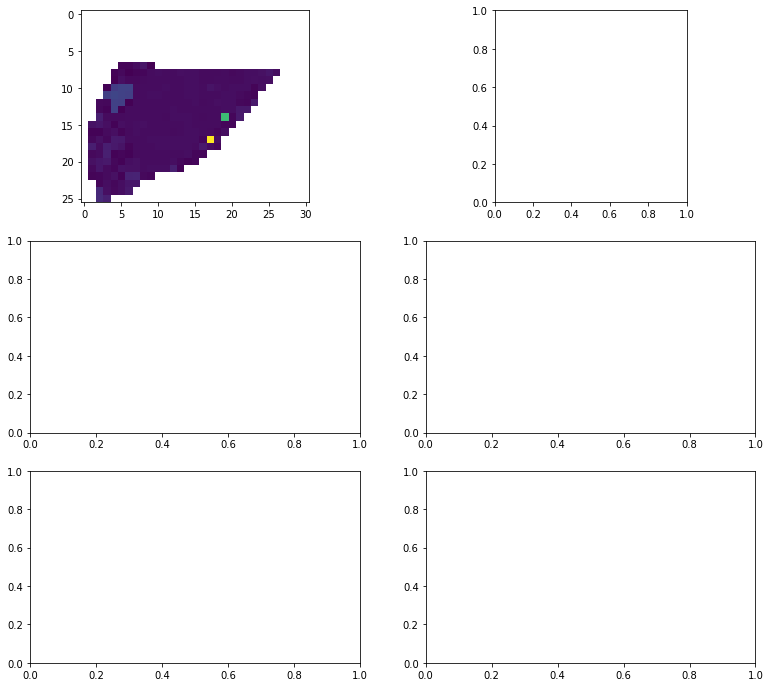

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(13, 12))
axes[0, 0].imshow(wave_period)
axes[0, 1].imshow(wave_angle, cmap=cmocean.cm.phase, vmin=0, vmax=360)
axes[1, 0].imshow(R, cmap='Reds')
axes[1, 1].imshow(B, cmap='Blues')
axes[2, 0].imshow(G, cmap='Greens')
axes[2, 1].imshow(RGB)

In [ ]:
angle = np.ma.masked_invalid(ds.variables['CAngle'][i:i+10])


In [ ]:
times